# Web Search 2018 - Tutorial 2: Basic search spaces
## Contents

1. [Overview](#head1)
2. [Image data representations](#head2)
  1. [Load and visualize a sample image](#head21)
  2. [Histogram of Oriented Gradients](#head22)
  3. [Histogram of Color](#head23)
3. [Text data representations](#head3)
  1. [Load and visualize a text corpus](#head31)
  2. [Bag of words](#head32)
4. [Searching on a single feature space](#head4)
  1. [Distance metrics and normalization](#head41)
  2. [Bag of words](#head42)
  3. [Histogram of Oriented Gradients](#head43)
  4. [Histogram of Color](#head44)
5. [Exercises](#head5)


## <a name="head1"></a> Overview

The goal of this lab is to develop an architecture to search Text and Images, on different vector spaces.

We provide you with an example of how you can represent an image using the Histogram of Oriented Gradients image descriptor. Since one image is represented as a vector, you can represent multiple images as a matrix. Starting from this example, you can add other descriptors such as (HoC and GIST).

In summary, you should implement the following functionality:

* Individual feature vectors **normalization**;
* Extend the provided code to extract features from images of the project dataset, and **store them as a matrix**;
* Add support for **additional features**, apart from HoG: (HoC and GIST for now);
* **Bag of Words** representation for words. Store texts as a sparse matrix;
* Implement a straighforward search function for individual search spaces: Given an image/text as input, retrieve the **top-k nearest documents**, using an **adequate distance function**.


We strongly encourage you to use the [scikit-learn](http://scikit-learn.org/stable/) library. Most of the functionalities that you will need for you project are already implemented there.

In [754]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure
from skimage.color import rgb2gray
from skimage.io import imread
from skimage.transform import resize

from keras.preprocessing import image

# Hide all warnings
import warnings
warnings.filterwarnings('ignore')

# <a name="head2"></a> Image data representations
## <a name="head21"></a> Load and visualize a sample image

We start by loading an image. Then we do some pre-processing to prepare the image for feature extraction.

Our goal is to represent images using a fixed-length vector, despite the original image height and width. Therefore, we resize all images to a certain height and width.

In [755]:
def center_crop_image(im, size=224):

    if im.shape[2] == 4: # Remove the alpha channel
        im = im[:, :, 0:3]

    # Resize so smallest dim = 224, preserving aspect ratio
    h, w, _ = im.shape
    if h < w:
        im = resize(image=im, output_shape=(224, int(w * 224 / h)))
    else:
        im = resize(im, (int(h * 224 / w), 224))

    # Center crop to 224x224
    h, w, _ = im.shape
    im = im[h // 2 - 112:h // 2 + 112, w // 2 - 112:w // 2 + 112]
    
    return im

In [756]:
image1="cars.jpg"
image2="lena.jpg"
image3="street.jpg"
image4="bird.jpg"
image5="cup.jpg"
image6="red.jpg"
image7="strawberries.jpg"
image8="ferrari.jpg"
image9="bird2.jpg"
image10="street2.jpg"
image11="car2.jpg"
image12="fat_bird.jpg"
image13="flowers.jpg"
image14="flowers2.jpg"
image15="red2.jpg"

img = imread("data/" + image1)
print("Original shape: {}".format(img.shape))

Original shape: (2136, 3216, 3)


In order to keep the image aspect ratio, we crop the image at the center, and resize it:

In [757]:
## Resize image
#rgb = resize(rgb, (224, 224))

## Resize image with center cropping (square)
img = center_crop_image(img, size=224)
print("Final shape: {}".format(img.shape))

Final shape: (224, 224, 3)


For some image features, we do not need color information. Thus, we can convert the image to grayscale:

In [758]:
img_gray = rgb2gray(img)

print("Grayscale final shape: {}".format(img_gray.shape))

Grayscale final shape: (224, 224)


Visualize both resized original and grayscale images:

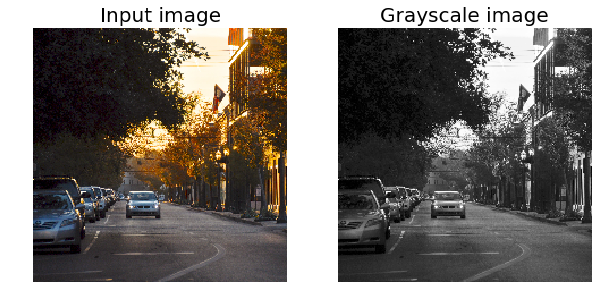

In [759]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img)
ax1.set_title('Input image', fontsize=20)
ax2.axis('off')
ax2.imshow(img_gray, cmap=plt.cm.gray)
ax2.set_title('Grayscale image', fontsize=20)
plt.show()

## <a name="head22"></a> Histogram of Oriented Gradients

#### Computing Histogram of Oriented Gradients (HoG) using skimage library. [HoG scikit-image Documentation](http://scikit-image.org/docs/0.14.x/api/skimage.feature.html#skimage.feature.hog)


In the HOG feature descriptor, the distribution ( histograms ) of directions of gradients ( oriented gradients ) are used as features. Gradients ( x and y derivatives ) of an image are useful as the magnitude of gradients is large around edges and corners ( regions of abrupt intensity changes ) and we know that edges and corners provide more information regarding object shapes than flat regions.


More about HoG descriptor: 
* http://mccormickml.com/2013/05/09/hog-person-detector-tutorial/
* http://mccormickml.com/2013/05/07/gradient-vectors/

In [760]:
fd, hog_image = hog(img_gray, orientations=8, pixels_per_cell=(16, 16), visualise=True)
print("HoG Feature vector shape: {}".format(fd.shape))

HoG Feature vector shape: (10368,)


Visualizing the computed HoG feature:

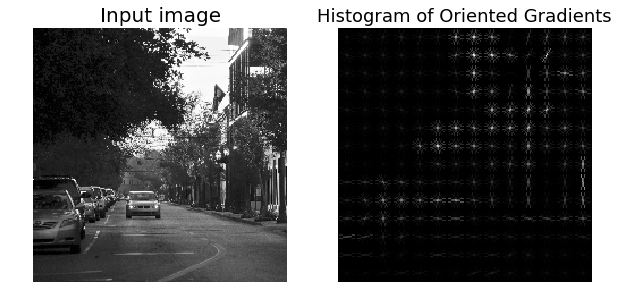

In [761]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img_gray, cmap=plt.cm.gray)
ax1.set_title('Input image', fontsize=20)

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients', fontsize=18)
plt.show()

## <a name="head23"></a> Histogram of Color

In [762]:
# Straight forward HoC implementation on RGB space
# For a more complete implementation, with better parametrization, etc., you can check the OpenCV library.

import matplotlib.pyplot as plt
import numpy as np

def hoc(im, bins=(16,16,16), hist_range=(256, 256, 256)):
    im_r = im[:,:,0]
    im_g = im[:,:,1]
    im_b = im[:,:,2]
    
    red_level = hist_range[0] / bins[0]
    green_level = hist_range[1] / bins[1]
    blue_level = hist_range[2] / bins[2]
    
    im_red_levels = im_r / red_level
    im_green_levels = im_g / green_level
    im_blue_levels = im_b / blue_level
    
    ind = im_blue_levels*bins[0]*bins[1]+ im_green_levels*bins[0] + im_red_levels
    
    hist_r, bins_r = np.histogram(ind.flatten(), bins[0]*bins[1]*bins[2])
    
    return hist_r, bins_r

In [763]:
from skimage import img_as_ubyte

# convert image pixels to [0, 255] range, and to uint8 type 
img_int = img_as_ubyte(img)

# Set bins range according to the image color space
hist_range_hsv=(180, 256, 256)
hist_range_rgb=(256, 256, 256)
hist_range = hist_range_rgb

# Compute histogram
hist, bin_edges = hoc(img_int, bins=(4,4,4), hist_range=hist_range)

#### Visualize the resulting histogram

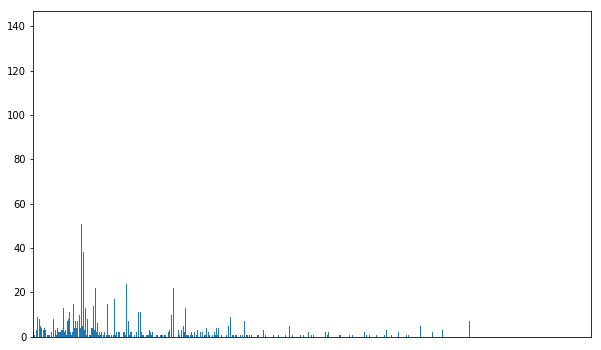

In [764]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.bar(bin_edges[:-1], hist, width=1)
ax.set_xticks([])
ax.set_xlim(bin_edges[:-1].min()*-2, max(bin_edges.max(), hist.shape[0]*1.3))
plt.show()

# <a name="head3"></a> Text data representations
## <a name="head31"></a> Corpus
We will use the brown corpus from NLTK. 

In [765]:
import nltk
from nltk.corpus import brown
nltk.download('brown')
corpus = brown.sents()

corpus = [" ".join(sent) for sent in corpus]
print("Total texts: {}".format(len(corpus)))

[nltk_data] Downloading package brown to
[nltk_data]     /Users/franciscorodrigues/nltk_data...
[nltk_data]   Package brown is already up-to-date!
Total texts: 57340


In [766]:
# Let's inspect some documents from the corpus
print("Doc 1: {}\nDoc 2: {}".format(corpus[2555], corpus[1112]))

Doc 1: Buchheister pledged the land would be an `` inviolate '' sanctuary for all birds , animals and plants .
Doc 2: She snapped five tenths of a second off the mark set by Helen Shipley , of Wellsley College , in the National A.A.U. meet in Columbus , Ohio .


## <a name="head32"></a> Bag-of-words
In the Bag of Words representation, documents are represented by a numerical sparse vector, whose dimension corresponds to the vocabulary size of the whole collection. Then, the set of all documents can be efficiently represented by a sparse matrix.

To illustrate this, consider the following corpus with two documents:

    corpus = [
                ["some random sentence"],  # doc1
                ["another sentence random sentence"] # doc2
             ]
The vocabulary size of our corpus is 4 (there are 4 different words). Thus, each document will be represented as a 4-dimensional numeric vector. Namely, assuming that we sort words alphabetically, we obtain:
    
            another, random, sentence, some
    doc1 = [   0,       1,      1,       1  ]
    doc1 = [   1,       1,      2,       0  ] 

Each entry denotes the counts of each word, in the document. Notice that we lose information regarding word order, in the BoW representation.

Using counts to create the BoW representation is among the most simple representations. There are alternative ways to do it which you can then explore such as TF-IDF, and others. For now, we will stick with BoW representation based on counts.

### Extracting BoW vectors
We will use the CountVectorizer class.
Check the documentation to understand the API and the default values of the supported parameters: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

The default tokenizer splits documents by whitespaces. This is far from optimal for Web text, but is a good starting point.

### Using a tokenizer from NLTK
When dealing with text gathered from the Web, it is crucial to have a good tokenizer. To understand why, inspect some of the documents from the brown corpus.

We will use one of the tokenizers available in NLTK together with the CountVectorizer class.

In [767]:
# NLTK Tokenizers documentation: https://www.nltk.org/api/nltk.tokenize.html

# from nltk.tokenize import TweetTokenizer
# tknzr = TweetTokenizer()

# Instantiate TreebankWordTokenizer
from nltk.tokenize import TreebankWordTokenizer
tknzr = TreebankWordTokenizer()

Create a CountVectorizer object and obtain the BoW sparse matrix for the corpus:

In [768]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer=tknzr.tokenize)
texts_bow = vectorizer.fit_transform(corpus)
print("texts_bow shape: {} - Type: {}".format(texts_bow.shape, type(texts_bow)))

texts_bow shape: (57340, 47623) - Type: <class 'scipy.sparse.csr.csr_matrix'>


The ```texts_bow``` variable is a sparse matrix. You can read more about sparse matrix (csr_matrix) here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html



Let's inspect the vocabulary:

In [769]:
vocabulary = vectorizer.vocabulary_
print("Vocabulary size: {}".format(len(vocabulary)))

Vocabulary size: 47623


The vocabulary size is huge and contains a lot of uninformative words. Let's do some pre-processing to reduce the vocabulary (e.g. remove Stopwords, remove rare words, etc.):

In [770]:
# remove stopwords, exclude words that appear less than 3 times
# Notice that the NLTK tokenizer is passed as parameter to CountVectorizer
vectorizer = CountVectorizer(stop_words="english", min_df=3, binary=False, tokenizer=tknzr.tokenize)
texts_bow = vectorizer.fit_transform(corpus)
vocabulary = vectorizer.vocabulary_
print("Vocabulary size: {}".format(len(vocabulary)))

Vocabulary size: 19789


Using these two pre-processing steps, it gets much better.

You can check CountVectorizer documentation for more pre-processing steps (e.g. lowercasing, better tokenizer, stemming, etc.) that may be adequate for your use-case.

# <a name="head4"></a> Searching on a single feature space

## <a name="head41"></a> Distance functions and normalization
Let's define a function that takes as input a query vector, and a matrix of target vectors (the 'database'), and returns the K-nearest neighbours. Make sure you understand the function below.

In [771]:
from sklearn.metrics import pairwise_distances

def k_neighbours(q, X, metric="euclidean", k=10):
    # Check pairwise_distances function docs: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html#sklearn.metrics.pairwise_distances
    dists = pairwise_distances(q, X, metric=metric)
    
    # Dists gets a shape 1 x NumDocs. Convert it to shape NumDocs (i.e. drop the first dimension)
    dists = np.squeeze(dists)
    sorted_indexes = np.argsort(dists)
    
    return sorted_indexes[:k], dists[sorted_indexes[:k]]

#### Normalize vectors to unit length:

In [772]:
from sklearn.preprocessing import normalize
texts_bow = normalize(texts_bow, norm="l2")

## <a name="head42"></a> Bag of words

In order to match queries to documents, it is required to apply the same processing steps to both the query and the documents.
Prepare the text query:

In [773]:
query1 = "Lawyer of Boston Yankees in the National Football League"
query2 = "president kennedy"
query=query1

# Transform query in a BoW representation
query_bow = vectorizer.transform([query])
query_bow = normalize(query_bow, norm="l2")

#### Query the database using the prepared query:

The metric that we will use will be the cosine distance. 

The function ```pairwise_distances``` computes distances, not similarities. Thus, it will compute the cosine distance $1-cos(x,y)$. Note that this is not a proper metric, as it lacks the triangle inequality property. 

In [774]:
k_nearest_indexes, k_nearest_dists = k_neighbours(q=query_bow, X=texts_bow, metric="cosine", k=10)

In [775]:
# Inspecting the top-k results: list of tuples (index of document, distance to query, text of document)
list(zip(k_nearest_indexes,k_nearest_dists, [corpus[i] for i in k_nearest_indexes]))

[(1385,
  0.2614510541240034,
  "He was the lawyer for Ted Collins' old Boston Yankees in the National Football League ."),
 (1386,
  0.6913933000758161,
  'All was quiet in the office of the Yankees and the local National Leaguers yesterday .'),
 (1369,
  0.6913933000758161,
  'His goal was to obtain a National League team for this city .'),
 (1457,
  0.7388835160664532,
  'A formula to supply players for the new Minneapolis Vikings and the problem of increasing the 1961 schedule to fourteen games will be discussed by National Football League owners at a meeting at the Hotel Warwick today .'),
 (5636,
  0.7388835160664532,
  'When he came to Baltimore , he was leaving a team which was supposed to win the National League pennant , and he was joining what seemed to be a second division American League club .'),
 (1367,
  0.7388835160664532,
  'The 53-year-old Shea , a prominent corporation lawyer with a sports background , is generally recognized as the man most responsible for the immi

## <a name="head43"></a> Search on Histogram of Colors
Now we will use the same function, ```k_neighbours```, to search over image vector spaces.

In [776]:
#Images database
images = [image1, image2, image3, image4, image5, image6, image7, image8, image9, image10, image15]
bins=(4,4,4)

In [777]:
from skimage import img_as_ubyte
from sklearn.preprocessing import normalize
from skimage import color

feats = []
for img in images:
    img = imread("data/" + img)
    
    # resize image
    img = center_crop_image(img, size=224)
    
    # Change image color space from RGB to HSV. 
    # HSV color space was designed to more closely align with the way human vision perceive color-making attributes
    img = color.rgb2hsv(img)
    
    # convert image pixels to [0, 255] range, and to uint8 type
    img_int = img_as_ubyte(img)

    # Extract HoC features
    hist, bin_edges = hoc(img_int, bins=bins)
    
    # Normalize features
    # We add 1 dimension to comply with scikit-learn API
    hist = np.squeeze(normalize(hist.reshape(1, -1), norm="l2"))
    
    feats.append(hist)
    
# Creating a feature matrix for all images
feats = np.array(feats)

print("Shape of feature matrix: {}".format(feats.shape))

Shape of feature matrix: (11, 64)


In [778]:
# Prepare image query
# try the following: image 11, image12, image13
image_q = image13

img_q = imread("data/" + image_q)
img_q_hsv = color.rgb2hsv(img_q)
img_q_hsv = center_crop_image(img_q_hsv, size=224)
img_int = img_as_ubyte(img_q_hsv)
hist, bin_edges = hoc(img_int, bins=bins)

image_q_feat = np.squeeze(normalize(hist.reshape(1, -1), norm="l2"))
print("Image query feature dimension: {}".format(image_q_feat.shape))

Image query feature dimension: (64,)


In [779]:
# Use the implemented function to find the K nearest neighbours on the HoC image vector space.
k_nearest_indexes, k_nearest_dists = k_neighbours(q=image_q_feat.reshape(1,-1), X=feats, metric="euclidean", k=10)

In [780]:
# Inspecting the top-k results - list of tuples (image index, distance to query image, image name)
list(zip(k_nearest_indexes, k_nearest_dists, [images[i] for i in k_nearest_indexes]))

[(10, 0.8455827076457612, 'red2.jpg'),
 (6, 0.986324678078985, 'strawberries.jpg'),
 (8, 1.0448296559049441, 'bird2.jpg'),
 (9, 1.0707885308897747, 'street2.jpg'),
 (4, 1.1160161719713582, 'cup.jpg'),
 (1, 1.196451024197386, 'lena.jpg'),
 (3, 1.2150015422630334, 'bird.jpg'),
 (7, 1.2277716880389677, 'ferrari.jpg'),
 (0, 1.2329424465793042, 'cars.jpg'),
 (2, 1.2724341765040066, 'street.jpg')]

### Inspect Results of Image Search

Query image: flowers.jpg


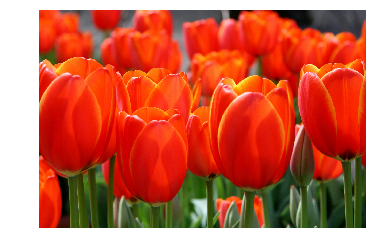

Image #0 - distance: 0.8455827076457612


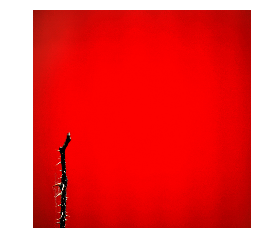

Image #1 - distance: 0.986324678078985


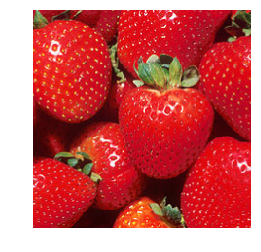

Image #2 - distance: 1.0448296559049441


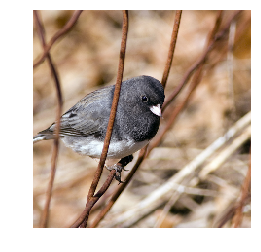

Image #3 - distance: 1.0707885308897747


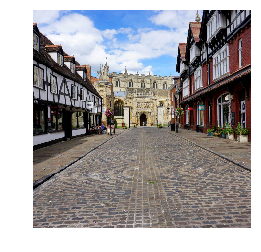

Image #4 - distance: 1.1160161719713582


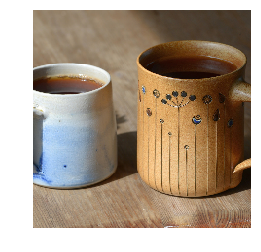

Image #5 - distance: 1.196451024197386


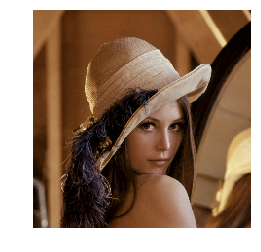

Image #6 - distance: 1.2150015422630334


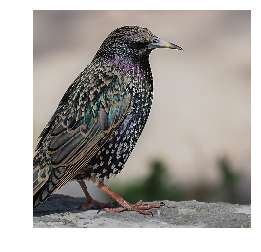

Image #7 - distance: 1.2277716880389677


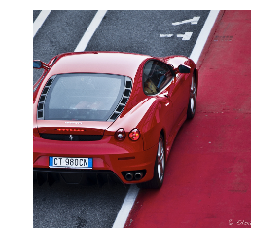

Image #8 - distance: 1.2329424465793042


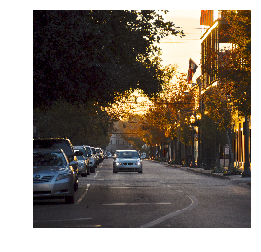

Image #9 - distance: 1.2724341765040066


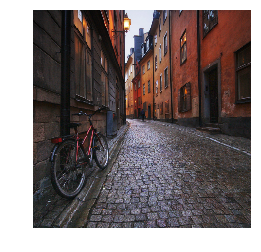

In [781]:
print("Query image: {}".format(image_q))
plt.imshow(img_q)
plt.axis('off')
plt.show()

for i, (img_idx, img_dist) in enumerate(zip(k_nearest_indexes,k_nearest_dists)):
    image_fname = images[img_idx]
    img = imread("data/" + image_fname)
    img = center_crop_image(img, size=224)
    print("Image #{} - distance: {}".format(i, img_dist))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    

##  <a name="head44"></a> Search on HoG vector space

In [782]:
#Images database
images = [image1, image2, image3, image4, image5, image6, image7, image8, image9, image10, image15]

pixels_per_cell=(32,32)
orientations=8

In [783]:
from skimage import img_as_ubyte
from sklearn.preprocessing import normalize
from skimage import color

feats = []
for img in images:
    img = imread("data/" + img)
    
    # resize image
    img = center_crop_image(img, size=224)
    
    # Convert to grayscale
    img = rgb2gray(img)
    
    # Extract HoG features
    hist = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell)
    
    # Normalize features
    # We add 1 dimension to comply with scikit-learn API
    hist = np.squeeze(normalize(hist.reshape(1, -1), norm="l2"))
    
    feats.append(hist)
    
# Creating a feature matrix for all images
feats = np.array(feats)

print("Shape of feature matrix: {}".format(feats.shape))

Shape of feature matrix: (11, 1800)


In [784]:
# Prepare image query
# try the following: image 11, image12, image13
image_q = image11

img_q = imread("data/" + image_q)
img_q = center_crop_image(img_q, size=224)
img_q = rgb2gray(img_q)

hist = hog(img_q, orientations=orientations, pixels_per_cell=pixels_per_cell)
image_q_feat = np.squeeze(normalize(hist.reshape(1, -1), norm="l2"))

print("Image query feature dimension: {}".format(image_q_feat.shape))

Image query feature dimension: (1800,)


In [785]:
# Use the implemented function to find the K nearest neighbours on the HoG image vector space.
k_nearest_indexes, k_nearest_dists = k_neighbours(q=image_q_feat.reshape(1,-1), X=feats, metric="euclidean", k=10)

In [786]:
# Inspecting the top-k results - list of tuples (image index, distance to query image, image name)
list(zip(k_nearest_indexes, k_nearest_dists, [images[i] for i in k_nearest_indexes]))

[(0, 0.7463754616671647, 'cars.jpg'),
 (9, 0.7735199346588301, 'street2.jpg'),
 (6, 0.7914610269484312, 'strawberries.jpg'),
 (2, 0.8637845789994857, 'street.jpg'),
 (7, 0.8880575932530621, 'ferrari.jpg'),
 (8, 0.8980364033789565, 'bird2.jpg'),
 (1, 0.9084019546140177, 'lena.jpg'),
 (10, 0.9166175661527224, 'red2.jpg'),
 (4, 0.9417338574692882, 'cup.jpg'),
 (5, 0.9999999999999997, 'red.jpg')]

## Inspect Results of Image Search

Query image: car2.jpg


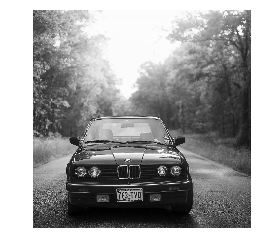

Image #0 - distance: 0.7463754616671647


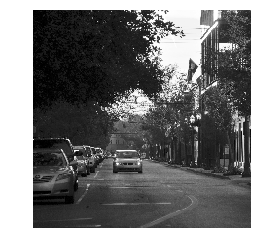

Image #1 - distance: 0.7735199346588301


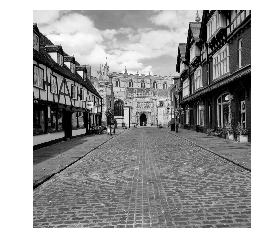

Image #2 - distance: 0.7914610269484312


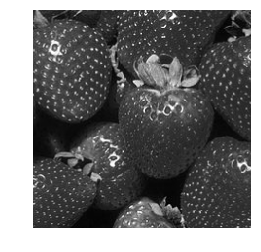

Image #3 - distance: 0.8637845789994857


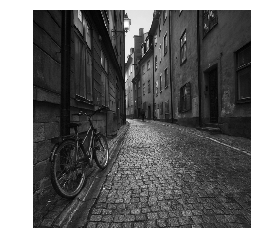

Image #4 - distance: 0.8880575932530621


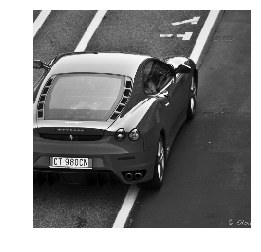

Image #5 - distance: 0.8980364033789565


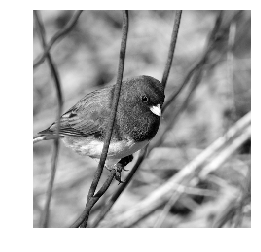

Image #6 - distance: 0.9084019546140177


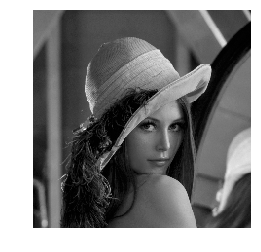

Image #7 - distance: 0.9166175661527224


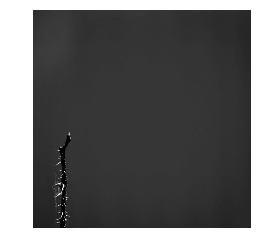

Image #8 - distance: 0.9417338574692882


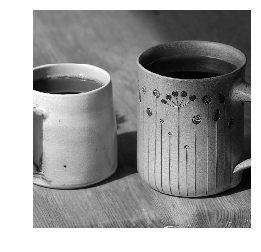

Image #9 - distance: 0.9999999999999997


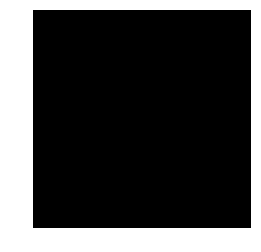

In [787]:
print("Query image: {}".format(image_q))
plt.imshow(img_q, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

for i, (img_idx, img_dist) in enumerate(zip(k_nearest_indexes,k_nearest_dists)):
    image_fname = images[img_idx]
    img = imread("data/" + image_fname)
    img = center_crop_image(img, size=224)
    img = rgb2gray(img)
    print("Image #{} - distance: {}".format(i, img_dist))
    plt.imshow(img, cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()
    

##  <a name="head5"></a> Exercises

In [788]:
# Plot the color histogram of each color channel. Use 32 bins per color channel.


In [789]:
# Inspect the BoW vocabulary and try to understand which additional filters you could apply to remove uninformative words.


In [790]:
# Modify or remove the normalization steps and repeat the experiments. Compare the results with the normalized version and discuss what you observe.


In [791]:
# Modify the metric for each space and repeat the experiments. Compare the results with the correct metric and discuss what you observe.


In [792]:
# Implement a visual search space with the GIST feature.
